In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
# Load the data
spurs = pd.read_csv('..\\data\\spurs.csv')
spurs = spurs[(spurs['season_type']==0)  &(spurs['season']<2020) & (spurs['season']>2000)].reset_index(drop=True)

## Using regular season games to predict regular season games

In [20]:
num_train_samples = int(0.6 * len(spurs))
num_val_samples = int(0.20 * len(spurs))
num_test_samples = len(spurs) - num_train_samples - num_val_samples

### Splitting data into Train, Validation, Test splits

In [11]:
sequence_length = 82
batch_size = 32
h = 1
delay = sequence_length + h - 1

scores=spurs['score']

train_dataset = keras.utils.timeseries_dataset_from_array(
    data = scores[:-delay],
    targets=scores[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    data = scores[:-delay],
    targets=scores[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    data = scores[:-delay],
    targets=scores[delay:],
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

### Testing the performance of architectures implemented in Assignment 7

In [12]:
num_features=1
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.SimpleRNN(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("RNN.keras",save_best_only=True, monitor='val_loss')]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("RNN.keras")
rnn_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {rnn_mae:.3f}")



Epoch 1/20


25/25 [==============================] - 2s 26ms/step - loss: 8433.2832 - mae: 91.0817 - val_loss: 9572.4102 - val_mae: 97.2237
Epoch 2/20
25/25 [==============================] - 0s 14ms/step - loss: 7855.7212 - mae: 87.8507 - val_loss: 9016.2598 - val_mae: 94.3210
Epoch 3/20
25/25 [==============================] - 0s 15ms/step - loss: 7502.4370 - mae: 85.8220 - val_loss: 8706.0645 - val_mae: 92.6623
Epoch 4/20
25/25 [==============================] - 0s 15ms/step - loss: 7225.4766 - mae: 84.1922 - val_loss: 8408.5400 - val_mae: 91.0427
Epoch 5/20
25/25 [==============================] - 0s 14ms/step - loss: 6956.1069 - mae: 82.5754 - val_loss: 8117.3335 - val_mae: 89.4292
Epoch 6/20
25/25 [==============================] - 0s 14ms/step - loss: 6691.7896 - mae: 80.9632 - val_loss: 7830.8447 - val_mae: 87.8128
Epoch 7/20
25/25 [==============================] - 0s 14ms/step - loss: 6433.1099 - mae: 79.3487 - val_loss: 7550.3091 - val_mae: 86.2006
Epoch 8/20
25/25 [=====

In [15]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
lstm = keras.Model(inputs, outputs)

lstm.summary()

callbacks = [keras.callbacks.ModelCheckpoint("LSTM.keras",save_best_only=True, monitor='val_loss')]
lstm.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = lstm.fit(train_dataset,
                    epochs=20,
                    validation_data=val_dataset,
                    callbacks=callbacks)

lstm = keras.models.load_model("LSTM.keras")
lstm_mae=lstm.evaluate(test_dataset)[1]
print(f"Test MAE: {lstm_mae:.3f}")

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 82, 1)]           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
25/25 [==============================] - 3s 48ms/step - loss: 9206.8223 - mae: 95.2228 - val_loss: 10235.0156 - val_mae: 100.5738
Epoch 2/20
25/25 [==============================] - 1s 30ms/step - loss: 8380.9775 - mae: 90.7888 - val_loss: 9480.4971 - val_mae: 96.7503
Epoch 3

In [16]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(128, recurrent_dropout=0.1, return_sequences=True)(inputs)
x = layers.SimpleRNN(128, recurrent_dropout=0.1)(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

callbacks=[keras.callbacks.ModelCheckpoint("RNN_LSTM_Stacked.keras",save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)

model = keras.models.load_model("RNN_LSTM_Stacked.keras")
rls_mae = model.evaluate(test_dataset)[1]
print(f"Test MAE: {rls_mae:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 82, 1)]           0         
                                                                 
 lstm_2 (LSTM)               (None, 82, 128)           66560     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 99585 (389.00 KB)
Trainable params: 99585 (389.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
25/25 [===

In [4]:
## Borrowed your function to evaluate the naive method
def evaluate_naive_method(dataset):
    total_abs_err = 0. # Initializes a variable to accumulate the total absolute error of the predictions. This is a floating-point variable, as indicated by the .0.
    samples_seen = 0   # Initializes a counter for the total number of samples (data points) seen during the evaluation.
    for samples, targets in dataset:
        preds = samples[:, -1] # naive forecast is the last value observed in the sequence
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0] # number of samples in the batch
    return total_abs_err / samples_seen

#print('Validation MAE:', evaluate_naive_method(test_dataset))

## Normalizing scores by defensive strength of opponent

In [5]:
def split_data(features, targets ,sequence_length, batch_size, h, splits=[0.6, 0.2, 0.2]):
    num_train_samples = int(splits[0] * len(features))
    num_val_samples = int(splits[1] * len(features))
    num_test_samples = len(features) - num_train_samples - num_val_samples
    delay = sequence_length + h - 1
    
    

    train_dataset = keras.utils.timeseries_dataset_from_array(
        data = features[:-delay],
        targets=targets[delay:],
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=0,
        end_index=num_train_samples)

    val_dataset = keras.utils.timeseries_dataset_from_array(
        data = features[:-delay],
        targets=targets[delay:],
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=num_train_samples,
        end_index=num_train_samples + num_val_samples)

    test_dataset = keras.utils.timeseries_dataset_from_array(
        data = features[:-delay],
        targets=targets[delay:],
        sequence_length=sequence_length,
        shuffle=True,
        batch_size=batch_size,
        start_index=num_train_samples + num_val_samples)

    return train_dataset, val_dataset, test_dataset



In [45]:
## Splitting data for the score_diff model

sequence_length = 16
batch_size = 32
h = 1
features = spurs['score_diff']

train_dataset, val_dataset, test_dataset = split_data(features, features, sequence_length, batch_size, h)

In [6]:
### function that implements the best performing model architecture
def stacked_model(filepath, train_dataset, val_dataset, sequence_length, num_features):

    inputs = keras.Input(shape=(sequence_length, num_features))
    x = layers.LSTM(128, recurrent_dropout=0.1, return_sequences=True)(inputs)
    x = layers.SimpleRNN(128, recurrent_dropout=0.1)(x)
    x = layers.Dropout(0.1)(x)
    outputs = layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    model.summary()

    callbacks=[keras.callbacks.ModelCheckpoint(filepath,save_best_only=True)]
    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    
    history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, callbacks=callbacks)
    return pd.DataFrame(history.history)


In [22]:
stacked_model("RNN_LSTM_Stacked.keras", train_dataset, val_dataset, sequence_length, num_features)

model = keras.models.load_model("RNN_LSTM_Stacked.keras")
rls_mae = model.evaluate(test_dataset)[1]
print(f"RLS Test MAE: {rls_mae:.3f}")
print('Naive Test MAE:', evaluate_naive_method(test_dataset))

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 16, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 16, 128)           66560     
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 99585 (389.00 KB)
Trainable params: 99585 (389.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
27/27 [===

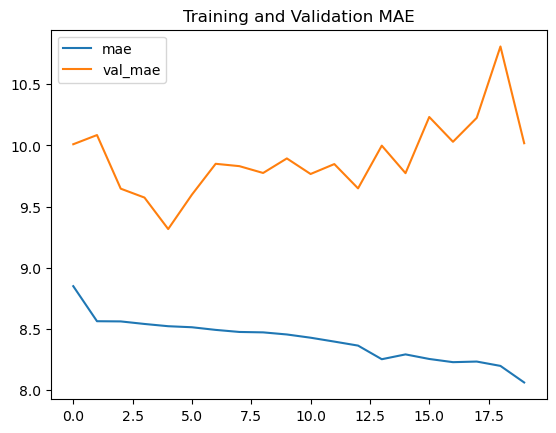

In [23]:
loss_df = pd.DataFrame(history.history)
loss_df[['mae', 'val_mae']].plot(legend=True, title='Training and Validation MAE')
plt.show()

## Expanding to multivariate

In [7]:
num_features = 3

sequence_length = 16
batch_size = 32
h = 1
features = spurs[['score_diff', 'pts_paint', 'turnovers']]
targets = spurs[['score_diff']]

train_dataset, val_dataset, test_dataset = split_data(features,targets, sequence_length, batch_size, h)

In [8]:
loss_df = stacked_model("RNN_LSTM_Stacked_3_features.keras", train_dataset, val_dataset, sequence_length, num_features)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 16, 128)           67584     
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               32896     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 100609 (393.00 KB)
Trainable params: 100609 (393.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

Epoch 1/20


27/27 

In [9]:
model = keras.models.load_model("RNN_LSTM_Stacked_2_features.keras")
rls_mae = model.evaluate(test_dataset)[1]
print(f"RLS Test MAE: {rls_mae:.3f}")

ValueError: in user code:

    File "c:\Users\bisho\.conda\envs\TensorFlow\lib\site-packages\keras\src\engine\training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\bisho\.conda\envs\TensorFlow\lib\site-packages\keras\src\engine\training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\bisho\.conda\envs\TensorFlow\lib\site-packages\keras\src\engine\training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\bisho\.conda\envs\TensorFlow\lib\site-packages\keras\src\engine\training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\bisho\.conda\envs\TensorFlow\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\bisho\.conda\envs\TensorFlow\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_9" is incompatible with the layer: expected shape=(None, 16, 2), found shape=(None, None, 3)


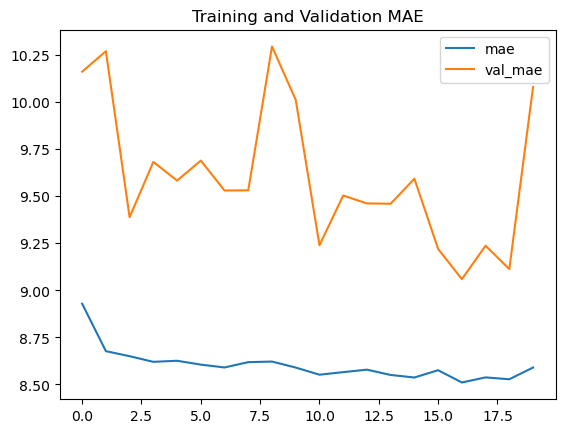

In [50]:
loss_df[['mae', 'val_mae']].plot(legend=True, title='Training and Validation MAE')
plt.show()